In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import folium
from geopy.geocoders import Nominatim
import re
import matplotlib

In [2]:
# 도시교통정보센터 - API

url = 'http://www.utic.go.kr/guide/getSafeOpenJson.do'
api_key = '9mtOhcOoc6Tx8NSTV0A751uXWLl5Kbk9hLOAEGXqb2c6JYsdqFEOZfpXkKBmy'
sidoCd = 11  # 원하는 시도 코드로 변경해주세요.

parameter = '?key={}&sidoCd={}'.format(api_key, sidoCd) 
url_with_params = url + parameter

response = requests.get(url_with_params)

json_data = response.json()
json_data

{'resultCode': '00',
 'totalCount': '3408',
 'items': [{'SNCT_SEQ': 50849,
   'REG_DT': '20231117',
   'MAX_SPD': 30,
   'MAX_SPD_ORG': 30,
   'CCTV_CNT': 1,
   'FCLTY_NM': '방배서리풀어린이집',
   'SIDO_NM': '서울특별시',
   'ROAD_WDT': '5',
   'CCTV_YN': '1 ',
   'ADDR': '서울특별시 서초구 서초대로29길 20 (방배동) (방배동)',
   'LADDR': '서울특별시 서초구 방배동 879-1 ',
   'POL_NM': '서울지방경찰청 서울방배',
   'SIGUN_CD': '11650',
   'SIGUN_NM': '서초구',
   'X': 126.99531141199307,
   'Y': 37.489232887570445,
   'GOV_NM': '교통행정과',
   'GOV_TEL': '025932233',
   'FCLTY_TY': '1',
   'GEOM': 'POLYGON((126.99485343433167 37.48967661481848,126.99564219679434 37.48845578098049,126.99569873148153 37.48848056076918,126.9949099696783 37.48970139497952,126.99485343433167 37.48967661481848))',
   'DATA_TYPE': 'C0103'},
  {'SNCT_SEQ': 50848,
   'REG_DT': '20231117',
   'MAX_SPD': 30,
   'MAX_SPD_ORG': 30,
   'CCTV_CNT': 1,
   'FCLTY_NM': '방배1동숲어린이집',
   'SIDO_NM': '서울특별시',
   'ROAD_WDT': '5',
   'CCTV_YN': '1 ',
   'ADDR': '서울특별시 서초구 방배로20길 25-19 (방

In [3]:
# 데이터프레임으로 불러오기
if 'items' in json_data:
    df = pd.DataFrame(json_data['items'])

In [4]:
# 원하는 열만 뽑아서 보기(MAX_SPD : 제한속도, SIDO_NM : 시도명, FCLTY_NM : 대상시설명, ROAD_WDT : 도로구역도로폭(NULL=O), CCTV_YN : CCTV 설치여부, LADDR : 지번주소, SIGUN_NM : 시군구명, X:경도, Y:위도, FCLTY_TY : 시설종류)
df = df[['MAX_SPD','SIDO_NM','FCLTY_NM','ROAD_WDT','CCTV_YN','LADDR','SIGUN_NM','X','Y','FCLTY_TY']]

In [5]:
# 시설종류 열 확인
df['FCLTY_TY'].unique()  # 1,2,3이라는 숫자(변수)로 시설종류(어린이, 노인, 장애인)가 이루어져 잇음
df['FCLTY_TY'].value_counts()  # 1=3127개, 2=265개, 3=16개

FCLTY_TY
1    3127
2     265
3      16
Name: count, dtype: int64

In [6]:
df[df['FCLTY_TY']=='3']  # 이렇게 확인해본 결과 1=어린이, 2=노인, 3=장애인

,MAX_SPD,SIDO_NM,FCLTY_NM,ROAD_WDT,CCTV_YN,LADDR,SIGUN_NM,X,Y,FCLTY_TY
2,30,서울특별시,동대문장애인종합복지관,0,1,서울특별시 동대문구 용두동 255-69 다사랑행복센터 동대문장애인종합복지관,동대문구,127.034084,37.571825,3
4,30,서울특별시,강남세움복지관,0,1,서울특별시 강남구 수서동 721 미미위강남세움센터 강남세움복지관,강남구,127.106944,37.486993,3
28,50,서울특별시,서울시립남부장애인 종합복지관,15,1,서울특별시 동작구 신대방동 722 서울시립남부장애인종합복지관 신대방동 722,동작구,126.916797,37.490300,3
60,30,서울특별시,홀트강동복지관,23,2,서울특별시 강동구 강일동 665-3 홀트강동복지관 홀트강동복지관,강동구,127.173289,37.566226,3
2040,30,서울특별시,늘푸른집,6~12,1,서울특별시 강서구 개화동 330 천주의성요한수도회 늘푸른집,강서구,126.811164,37.584455,3
2185,30,서울특별시,다니엘의집4호,4,2,,강남구,127.021003,37.515144,3
2186,30,서울특별시,사랑쉼터의 집,9~21,1,서울특별시 강동구 상일동 473-1 사랑쉼터의 집 사랑쉼터의집,강동구,127.167256,37.546769,3
2187,30,서울특별시,암사재활원,17,1,서울특별시 강동구 암사동 196-1 암사재활원 암사재활원,강동구,127.131414,37.558380,3
2212,30,서울특별시,늘푸른나무복지관,25,2,서울특별시 강서구 가양동 1470-2 늘푸른나무 복지관 .,강서구,126.851000,37.568492,3
2213,30,서울특별시,늘푸른나무복지관,8,1,서울특별시 강서구 가양동 1470-2 늘푸른나무 복지관 .,강서구,126.851000,37.568492,3


In [7]:
matplotlib.rcParams['font.family'] = 'malgun Gothic'   # '맑은 고딕'으로 설정 
matplotlib.rcParams['axes.unicode_minus'] = False     # 한글 폰트를 지정한 후 그래프에서 마이너스(-) 폰트가 깨지는 것을 막아줌

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


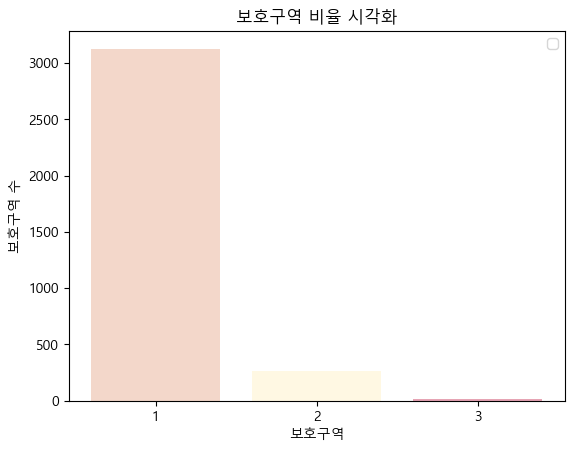

In [8]:
# <보호구역 비율 시각화>

# 'FCLTY_TY' 열의 값별 개수 계산
counts = df['FCLTY_TY'].value_counts()

# 색
c = ['#F3D7CA','#FFF8E3','#E6A4B4']

# 바 그래프 그리기
plt.bar(counts.index, counts.values, color = c)
plt.xlabel('보호구역')
plt.ylabel('보호구역 수')
plt.title('보호구역 비율 시각화')
plt.legend()
plt.show()

In [9]:
# 한글파일을 바탕으로 만든 데이터프레임과 맞는지 확인하기
df_check = df[df['FCLTY_TY']=='3']  # 장애인 보호구역=3이여서 3으로 확인
df_check

,MAX_SPD,SIDO_NM,FCLTY_NM,ROAD_WDT,CCTV_YN,LADDR,SIGUN_NM,X,Y,FCLTY_TY
2,30,서울특별시,동대문장애인종합복지관,0,1,서울특별시 동대문구 용두동 255-69 다사랑행복센터 동대문장애인종합복지관,동대문구,127.034084,37.571825,3
4,30,서울특별시,강남세움복지관,0,1,서울특별시 강남구 수서동 721 미미위강남세움센터 강남세움복지관,강남구,127.106944,37.486993,3
28,50,서울특별시,서울시립남부장애인 종합복지관,15,1,서울특별시 동작구 신대방동 722 서울시립남부장애인종합복지관 신대방동 722,동작구,126.916797,37.490300,3
60,30,서울특별시,홀트강동복지관,23,2,서울특별시 강동구 강일동 665-3 홀트강동복지관 홀트강동복지관,강동구,127.173289,37.566226,3
2040,30,서울특별시,늘푸른집,6~12,1,서울특별시 강서구 개화동 330 천주의성요한수도회 늘푸른집,강서구,126.811164,37.584455,3
2185,30,서울특별시,다니엘의집4호,4,2,,강남구,127.021003,37.515144,3
2186,30,서울특별시,사랑쉼터의 집,9~21,1,서울특별시 강동구 상일동 473-1 사랑쉼터의 집 사랑쉼터의집,강동구,127.167256,37.546769,3
2187,30,서울특별시,암사재활원,17,1,서울특별시 강동구 암사동 196-1 암사재활원 암사재활원,강동구,127.131414,37.558380,3
2212,30,서울특별시,늘푸른나무복지관,25,2,서울특별시 강서구 가양동 1470-2 늘푸른나무 복지관 .,강서구,126.851000,37.568492,3
2213,30,서울특별시,늘푸른나무복지관,8,1,서울특별시 강서구 가양동 1470-2 늘푸른나무 복지관 .,강서구,126.851000,37.568492,3


In [10]:
# 'fclty_nm' 열을 기준으로 중복된 행 제거 => 10개의 보호구역이 나옴
new_df = df_check.drop_duplicates(subset='FCLTY_NM')
new_df

,MAX_SPD,SIDO_NM,FCLTY_NM,ROAD_WDT,CCTV_YN,LADDR,SIGUN_NM,X,Y,FCLTY_TY
2,30,서울특별시,동대문장애인종합복지관,0,1,서울특별시 동대문구 용두동 255-69 다사랑행복센터 동대문장애인종합복지관,동대문구,127.034084,37.571825,3
4,30,서울특별시,강남세움복지관,0,1,서울특별시 강남구 수서동 721 미미위강남세움센터 강남세움복지관,강남구,127.106944,37.486993,3
28,50,서울특별시,서울시립남부장애인 종합복지관,15,1,서울특별시 동작구 신대방동 722 서울시립남부장애인종합복지관 신대방동 722,동작구,126.916797,37.490300,3
60,30,서울특별시,홀트강동복지관,23,2,서울특별시 강동구 강일동 665-3 홀트강동복지관 홀트강동복지관,강동구,127.173289,37.566226,3
2040,30,서울특별시,늘푸른집,6~12,1,서울특별시 강서구 개화동 330 천주의성요한수도회 늘푸른집,강서구,126.811164,37.584455,3
2185,30,서울특별시,다니엘의집4호,4,2,,강남구,127.021003,37.515144,3
2186,30,서울특별시,사랑쉼터의 집,9~21,1,서울특별시 강동구 상일동 473-1 사랑쉼터의 집 사랑쉼터의집,강동구,127.167256,37.546769,3
2187,30,서울특별시,암사재활원,17,1,서울특별시 강동구 암사동 196-1 암사재활원 암사재활원,강동구,127.131414,37.558380,3
2212,30,서울특별시,늘푸른나무복지관,25,2,서울특별시 강서구 가양동 1470-2 늘푸른나무 복지관 .,강서구,126.851000,37.568492,3
3265,30,서울특별시,신아재활원,11,1,서울특별시 송파구 거여동 251-23 신아원 신아재활원,송파구,127.145469,37.491457,3


-> 한글파일과 비교해본 결과 API에서는 동대문장애인종합복지관, HWP 파일에서는 임마누엘 집 이 두개가 다르다는 것을 확인할 수 있음. 이 두가지를 로드뷰를 확인해본 결과 임마누엘집 근처에는 장애인보호구역 안내가 있었지만, 동대문구에서는 없었기 때문에 HWP파일을 사용하기로 결정.

In [11]:
# API에 있던 좌표를 데이터프레임으로 만들기
latlog = pd.DataFrame({'latitude':[37.584455,37.568492,37.490300,37.515144,37.486993,37.491457,0,37.558380,37.546769,37.566226],
                       'longitude':[126.8112,126.8510,126.9168,127.0210,127.1069,127.1455,0,127.1314,127.1673,127.1733]})
latlog

,latitude,longitude
0,37.584455,126.8112
1,37.568492,126.8510
2,37.490300,126.9168
3,37.515144,127.0210
4,37.486993,127.1069
5,37.491457,127.1455
6,0.000000,0.0000
7,37.558380,127.1314
8,37.546769,127.1673
9,37.566226,127.1733


### 장애인보호구역+사회복지시설

In [12]:
# 서울시 사회복지시설 목록 불러오기
welfare = pd.read_csv('./서울시 사회복지시설 목록.csv', encoding='cp949')
welfare

,시설명,시설코드,시설종류명(시설유형),시설종류상세명(시설종류),자치구(시)구분,시설장명,시군구코드,시군구명,시설주소,정원(수용인원),현인원,전화번호,우편번호
0,서울꽃동네신내노인요양원,A0001,(노인) 노인요양시설,노인의료복지시설,자치구,최은숙,1126000000,중랑구,서울특별시 중랑구 신내로 194,234.0,234.0,02-490-2609,02052
1,청운양로원,A0002,(노인) 양로시설,노인주거복지시설,자치구,이종명,1111000000,종로구,서울특별시 종로구 비봉길 76 (구기동),57.0,50.0,02-379-9232,03001
2,청운노인요양원,A0003,(노인) 노인요양시설,노인의료복지시설,자치구,이종후,1111000000,종로구,서울특별시 종로구 비봉길 76 (구기동),45.0,45.0,02-3217-0057,03001
3,홍파양로원,A0004,(노인) 양로시설,노인주거복지시설,자치구,김우리,1135000000,노원구,서울특별시 노원구 동일로248길 30 (상계동),44.0,32.0,02-939-0735,01623
4,천사노인요양원,A0007,(노인) 노인요양시설,노인의료복지시설,자치구,김샛별,1150000000,강서구,서울특별시 강서구 강서로45다길 30-22,161.0,151.0,02-2602-2443,07704
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4105,강남발달장애인평생교육센터,Z6325,(장애인) (기타)장애인복지시설,장애인기타,자치구,김미현,1168000000,강남구,"서울특별시 강남구 논현로86길 21, 2층 (역삼동)",24.0,NaN,07043544701,06220
4106,도봉발달장애인 평생교육센터,Z6399,(장애인) (기타)장애인복지시설,장애인기타,자치구,성효진,1132000000,도봉구,"서울특별시 도봉구 마들로 703, 4~6층 (도봉동)",30.0,NaN,029557979,01327
4107,염리종합사회복지관,Z6469,(일반) 사회복지관,일반사회복지시설,자치구,최상진,1144000000,마포구,서울특별시 마포구 대흥로24길 50 (염리동),NaN,NaN,02-3276-1803,04123
4108,서초1인가구지원센터,Z6475,(기타) 기타시설,기타시설,자치구,엄준,1165000000,서초구,"서울특별시 서초구 사평대로 273, 4층 (반포동)",NaN,NaN,0221558283,06544


In [13]:
# 사회복지시설 목록 중 필요한 열만 뽑기
welfare_df = welfare[['시군구명','시설명','시설주소','시설종류명(시설유형)','정원(수용인원)','현인원']]
welfare_df

,시군구명,시설명,시설주소,시설종류명(시설유형),정원(수용인원),현인원
0,중랑구,서울꽃동네신내노인요양원,서울특별시 중랑구 신내로 194,(노인) 노인요양시설,234.0,234.0
1,종로구,청운양로원,서울특별시 종로구 비봉길 76 (구기동),(노인) 양로시설,57.0,50.0
2,종로구,청운노인요양원,서울특별시 종로구 비봉길 76 (구기동),(노인) 노인요양시설,45.0,45.0
3,노원구,홍파양로원,서울특별시 노원구 동일로248길 30 (상계동),(노인) 양로시설,44.0,32.0
4,강서구,천사노인요양원,서울특별시 강서구 강서로45다길 30-22,(노인) 노인요양시설,161.0,151.0
...,...,...,...,...,...,...
4105,강남구,강남발달장애인평생교육센터,"서울특별시 강남구 논현로86길 21, 2층 (역삼동)",(장애인) (기타)장애인복지시설,24.0,NaN
4106,도봉구,도봉발달장애인 평생교육센터,"서울특별시 도봉구 마들로 703, 4~6층 (도봉동)",(장애인) (기타)장애인복지시설,30.0,NaN
4107,마포구,염리종합사회복지관,서울특별시 마포구 대흥로24길 50 (염리동),(일반) 사회복지관,NaN,NaN
4108,서초구,서초1인가구지원센터,"서울특별시 서초구 사평대로 273, 4층 (반포동)",(기타) 기타시설,NaN,NaN


In [14]:
# 시설종류명(시설유형)에 '장애'가 포함되어 있는 것만 뽑기 + 인덱스 재정렬
df_welfare = welfare_df[welfare_df['시설종류명(시설유형)'].str.contains('장애')]
df_welfare = df_welfare.reset_index(drop=True)
df_welfare

,시군구명,시설명,시설주소,시설종류명(시설유형),정원(수용인원),현인원
0,송파구,송파구방이복지관,서울특별시 송파구 백제고분로37길 4 (석촌동)(석촌동),(장애인) 장애인복지관,160.0,160.0
1,송파구,서울시각장애인복지관,서울특별시 송파구 삼학사로19길 27,(장애인) 장애인복지관,0.0,0.0
2,동작구,서울시립발달장애인복지관,서울특별시 동작구 여의대방로20길 33-0395(보라매공원내),(장애인) 장애인복지관,752.0,752.0
3,강남구,청음복지관,서울특별시 강남구 봉은사로50길 6,(장애인) 장애인복지관,NaN,345.0
4,마포구,마포장애인종합복지관,서울특별시 마포구 성산로4길 353층(마포장애인종합복지관)(성산동),(장애인) 장애인복지관,NaN,3743.0
...,...,...,...,...,...,...
679,종로구,종로발달장애인평생교육센터,서울특별시 종로구 종로17길 8 (종로2가),(장애인) (기타)장애인복지시설,30.0,NaN
680,영등포구,영등포구 발달장애인평생교육센터,"서울특별시 영등포구 문래북로 1055~7층, 어울림센터 (당산동1가)",(장애인) (기타)장애인복지시설,NaN,NaN
681,강남구,강남발달장애인평생교육센터,"서울특별시 강남구 논현로86길 21, 2층 (역삼동)",(장애인) (기타)장애인복지시설,24.0,NaN
682,도봉구,도봉발달장애인 평생교육센터,"서울특별시 도봉구 마들로 703, 4~6층 (도봉동)",(장애인) (기타)장애인복지시설,30.0,NaN


In [15]:
# 시설 주소의 null값 확인
df_welfare['시설주소'].isnull().sum()  # 5개의 결측값 존재
df_welfare[df_welfare['시설주소'].isnull()]  # 결측값 존재하는 행 확인

,시군구명,시설명,시설주소,시설종류명(시설유형),정원(수용인원),현인원
67,노원구,쉼터,NaN,(장애인) 중증장애인거주시설,70.0,57.0
302,강동구,사랑쉼터의집,NaN,(장애인) 장애유형별거주시설,29.0,21.0
639,성북구,성북피해장애인쉼터,NaN,(장애인) 피해장애인쉼터,8.0,NaN
646,서초구,단양노인장애인복지관,NaN,(장애인) 장애인근로사업장,NaN,NaN
647,서초구,금강직업재활시설,NaN,(장애인) 장애인근로사업장,NaN,NaN


In [16]:
# 시설주소가 없는 시설에 시설주소 추가
df_welfare['시설주소'][df_welfare['시설명']=='사랑쉼터의집'] = '서울특별시 강동구 상암로79길 24'
df_welfare['시설주소'][df_welfare['시설명']=='성북피해장애인쉼터'] = '서울특별시 성북구 화랑로 134'

C:\Users\moool\AppData\Local\Temp\ipykernel_18036\3902850333.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_welfare['시설주소'][df_welfare['시설명']=='사랑쉼터의집'] = '서울특별시 강동구 상암로79길 24'
C:\Users\moool\AppData\Local\Temp\ipykernel_18036\3902850333.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_welfare['시설주소'][df_welfare['시설명']=='성북피해장애인쉼터'] = '서울특별시 성북구 화랑로 134'


In [17]:
# 시설주소를 못 찾는 시설은 제거
df_welfare = df_welfare.drop([67, 646, 647])
df_welfare = df_welfare.reset_index(drop=True)
df_welfare

,시군구명,시설명,시설주소,시설종류명(시설유형),정원(수용인원),현인원
0,송파구,송파구방이복지관,서울특별시 송파구 백제고분로37길 4 (석촌동)(석촌동),(장애인) 장애인복지관,160.0,160.0
1,송파구,서울시각장애인복지관,서울특별시 송파구 삼학사로19길 27,(장애인) 장애인복지관,0.0,0.0
2,동작구,서울시립발달장애인복지관,서울특별시 동작구 여의대방로20길 33-0395(보라매공원내),(장애인) 장애인복지관,752.0,752.0
3,강남구,청음복지관,서울특별시 강남구 봉은사로50길 6,(장애인) 장애인복지관,NaN,345.0
4,마포구,마포장애인종합복지관,서울특별시 마포구 성산로4길 353층(마포장애인종합복지관)(성산동),(장애인) 장애인복지관,NaN,3743.0
...,...,...,...,...,...,...
676,종로구,종로발달장애인평생교육센터,서울특별시 종로구 종로17길 8 (종로2가),(장애인) (기타)장애인복지시설,30.0,NaN
677,영등포구,영등포구 발달장애인평생교육센터,"서울특별시 영등포구 문래북로 1055~7층, 어울림센터 (당산동1가)",(장애인) (기타)장애인복지시설,NaN,NaN
678,강남구,강남발달장애인평생교육센터,"서울특별시 강남구 논현로86길 21, 2층 (역삼동)",(장애인) (기타)장애인복지시설,24.0,NaN
679,도봉구,도봉발달장애인 평생교육센터,"서울특별시 도봉구 마들로 703, 4~6층 (도봉동)",(장애인) (기타)장애인복지시설,30.0,NaN


In [18]:
# 시설명과 시군구명이 같은 행 확인
df_welfare[df_welfare.duplicated(subset=['시군구명', '시설명'], keep=False)]  # 총 3개의 행(가장 앞쪽에 있는 행) 외의 다른 데이터는 제거할 예정

,시군구명,시설명,시설주소,시설종류명(시설유형),정원(수용인원),현인원
610,노원구,킨더윌언어심리전문센터,"서울특별시 노원구 상계로23다길 13-8, 1층 107-1,7,8호 (상계동, 노원...",(장애인) 장애인재활치료시설,150.0,NaN
628,중랑구,소담,"서울특별시 중랑구 상봉로 69, 5층 (면목동)",(장애인) 장애인보호작업장,15.0,NaN
635,은평구,스프링샤인,서울특별시 은평구 갈현로11길 30 (구산동),(장애인) 장애인보호작업장,20.0,12.0
636,중랑구,소담,"서울특별시 중랑구 상봉로69 (면목동, 한솔빌딩 5층)",(장애인) 장애인보호작업장,15.0,NaN
646,노원구,킨더윌언어심리전문센터,"서울특별시 노원구 상계로23다길 13-8107호 (상계동, 노원 아이파크)",(장애인) 장애인재활치료시설,NaN,0.0
653,중랑구,소담,서울특별시 중랑구 상봉로 695층 (면목동),(장애인) 장애인보호작업장,15.0,NaN
655,은평구,스프링샤인,서울특별시 은평구 갈현로11길 30 (구산동),(장애인) 장애인보호작업장,20.0,10.0


In [19]:
# '시설명'과 '시군구명'이 같은 행을 찾아냅니다.
duplicated_rows = df_welfare[df_welfare.duplicated(subset=['시군구명', '시설명'], keep=False)]

# 첫 세 행을 제외한 나머지 행의 인덱스를 가져옴
drop_indices = duplicated_rows.index[3:]

# 해당 인덱스의 행을 제거
df_wel = df_welfare.drop(drop_indices)
df_wel = df_wel.reset_index(drop=True)
df_wel

,시군구명,시설명,시설주소,시설종류명(시설유형),정원(수용인원),현인원
0,송파구,송파구방이복지관,서울특별시 송파구 백제고분로37길 4 (석촌동)(석촌동),(장애인) 장애인복지관,160.0,160.0
1,송파구,서울시각장애인복지관,서울특별시 송파구 삼학사로19길 27,(장애인) 장애인복지관,0.0,0.0
2,동작구,서울시립발달장애인복지관,서울특별시 동작구 여의대방로20길 33-0395(보라매공원내),(장애인) 장애인복지관,752.0,752.0
3,강남구,청음복지관,서울특별시 강남구 봉은사로50길 6,(장애인) 장애인복지관,NaN,345.0
4,마포구,마포장애인종합복지관,서울특별시 마포구 성산로4길 353층(마포장애인종합복지관)(성산동),(장애인) 장애인복지관,NaN,3743.0
...,...,...,...,...,...,...
672,종로구,종로발달장애인평생교육센터,서울특별시 종로구 종로17길 8 (종로2가),(장애인) (기타)장애인복지시설,30.0,NaN
673,영등포구,영등포구 발달장애인평생교육센터,"서울특별시 영등포구 문래북로 1055~7층, 어울림센터 (당산동1가)",(장애인) (기타)장애인복지시설,NaN,NaN
674,강남구,강남발달장애인평생교육센터,"서울특별시 강남구 논현로86길 21, 2층 (역삼동)",(장애인) (기타)장애인복지시설,24.0,NaN
675,도봉구,도봉발달장애인 평생교육센터,"서울특별시 도봉구 마들로 703, 4~6층 (도봉동)",(장애인) (기타)장애인복지시설,30.0,NaN


In [20]:
# 위도, 경도를 변환하기 위해 정리한 파일을 저장
df_wel.to_excel('./df_welfare.xlsx', index=False)

- 주소를 위도, 경도로 변환하기
- sheet -> 확장프로그램 -> geocoding -> 시설주소
- xlsx 파일 정리함

In [32]:
# 위도,경도 추가한 복지시설 데이터 불러오기
geocode_data = pd.read_excel('./geocode_welfare.xlsx')
geocode_data

,시군구명,시설명,시설주소,Latitude,Longitude,시설종류명(시설유형),정원(수용인원),현인원
0,송파구,송파구방이복지관,서울특별시 송파구 백제고분로37길 4 (석촌동)(석촌동),37.505381,127.097852,(장애인) 장애인복지관,160.0,160.0
1,송파구,서울시각장애인복지관,서울특별시 송파구 삼학사로19길 27,37.506119,127.094073,(장애인) 장애인복지관,0.0,0.0
2,동작구,서울시립발달장애인복지관,서울특별시 동작구 여의대방로20길 33-0395(보라매공원내),37.493234,126.919712,(장애인) 장애인복지관,752.0,752.0
3,강남구,청음복지관,서울특별시 강남구 봉은사로50길 6,37.509405,127.042358,(장애인) 장애인복지관,NaN,345.0
4,마포구,마포장애인종합복지관,서울특별시 마포구 성산로4길 353층(마포장애인종합복지관)(성산동),37.563706,126.909068,(장애인) 장애인복지관,NaN,3743.0
...,...,...,...,...,...,...,...,...
672,종로구,종로발달장애인평생교육센터,서울특별시 종로구 종로17길 8 (종로2가),37.570812,126.984944,(장애인) (기타)장애인복지시설,30.0,NaN
673,영등포구,영등포구 발달장애인평생교육센터,"서울특별시 영등포구 문래북로 1055~7층, 어울림센터 (당산동1가)",37.521684,126.898513,(장애인) (기타)장애인복지시설,NaN,NaN
674,강남구,강남발달장애인평생교육센터,"서울특별시 강남구 논현로86길 21, 2층 (역삼동)",37.500322,127.039177,(장애인) (기타)장애인복지시설,24.0,NaN
675,도봉구,도봉발달장애인 평생교육센터,"서울특별시 도봉구 마들로 703, 4~6층 (도봉동)",37.673059,127.046317,(장애인) (기타)장애인복지시설,30.0,NaN


In [33]:
# geocode_data에서 위도,경도 결측값 확인
geocode_data['Latitude'].isnull().sum()  # 3개의 결측값 존재
geocode_data[geocode_data['Latitude'].isnull()]  # 결측값 존재하는 행 확인

,시군구명,시설명,시설주소,Latitude,Longitude,시설종류명(시설유형),정원(수용인원),현인원
271,마포구,마포장애인주간보호센터,서울특별시 마포구 성산로4길 35마포장애인종합복지관 (성산동),NaN,NaN,(장애인) 장애인주간보호시설,12.0,10.0
574,성동구,성동재활의원,"서울특별시 성동구 뚝섬로1길 43, 1층 (성수동1가, 성수문화복지회관)",NaN,NaN,(장애인) 장애인의료재활시설,30.0,30.0
616,양천구,양천희망돌봄센터,"서울특별시 양천구 가로공원로 101 (신월동, 신월누리복지센터)",NaN,NaN,(장애인) 장애인주간보호시설,10.0,10.0


In [34]:
# 위도, 경도 데이터 추가하기
geocode_data.loc[271, ['Latitude', 'Longitude']] = [37.563787,126.908474]
geocode_data.loc[574, ['Latitude', 'Longitude']] = [37.545406, 127.046983]
geocode_data.loc[616, ['Latitude', 'Longitude']] = [37.535930, 126.827253]

In [35]:
# 결측값 처리 끝!
geocode_data[['Latitude','Longitude']].isnull().sum()

Latitude     0
Longitude    0
dtype: int64

In [37]:
# 서울 지역 외의 값이 존재함
selected = geocode_data[~geocode_data['시설주소'].str.contains('서울')]
selected

,시군구명,시설명,시설주소,Latitude,Longitude,시설종류명(시설유형),정원(수용인원),현인원
11,양천구,누림홈,경기도 김포시 대곶면 율생중앙로 83,37.654949,126.580436,(장애인) 장애유형별거주시설,70.0,58.0
20,양천구,해맑은마음터,경기도 김포시 대곶면 율생중앙로 89,37.655318,126.580311,(장애인) 중증장애인거주시설,77.0,69.0
24,종로구,문혜장애인요양원,강원도 철원군 갈말읍 텃골1길 13문혜장애인요양원,38.188643,127.366426,(장애인) 중증장애인거주시설,200.0,146.0
25,마포구,참 좋은집,충청북도 충주시 산척면 지속골길 71,37.063820,127.970669,(장애인) 중증장애인거주시설,30.0,30.0
28,송파구,생수의집,경기 포천시 군내면청군로 2813-18(직두리 155-5),37.866527,127.248161,(장애인) 중증장애인거주시설,56.0,41.0
29,관악구,에스알씨(SRC)보듬터,경기도 광주시 경수길 25-0SRC보듬터,37.419935,127.286961,(장애인) 장애유형별거주시설,55.0,54.0
32,종로구,은혜장애인요양원,강원 철원군 갈말읍 텃골1길 19호,38.191321,127.368051,(장애인) 중증장애인거주시설,228.0,160.0
39,마포구,마리스타보호작업장,충청북도 충주시 지속골길 71,37.063820,127.970669,(장애인) 장애인보호작업장,30.0,32.0
41,영등포구,한사랑장애영아원,경기도 광주시 초월읍 산수로554번길 59-14,37.411510,127.314148,(장애인) 장애영유아거주시설,65.0,50.0
60,영등포구,한사랑마을,경기도 광주시 산수로554번길 59-14(영등포구),37.411510,127.314148,(장애인) 중증장애인거주시설,80.0,80.0


In [38]:
# 서울 외의 지역 제거
# '시설주소' 열의 값에 '서울'이 포함되지 않는 행의 인덱스 가져오기
drop_index = geocode_data[~geocode_data['시설주소'].str.contains('서울')].index

# 해당 행 제거
geocode_data = geocode_data.drop(drop_index)
geocode_data

,시군구명,시설명,시설주소,Latitude,Longitude,시설종류명(시설유형),정원(수용인원),현인원
0,송파구,송파구방이복지관,서울특별시 송파구 백제고분로37길 4 (석촌동)(석촌동),37.505381,127.097852,(장애인) 장애인복지관,160.0,160.0
1,송파구,서울시각장애인복지관,서울특별시 송파구 삼학사로19길 27,37.506119,127.094073,(장애인) 장애인복지관,0.0,0.0
2,동작구,서울시립발달장애인복지관,서울특별시 동작구 여의대방로20길 33-0395(보라매공원내),37.493234,126.919712,(장애인) 장애인복지관,752.0,752.0
3,강남구,청음복지관,서울특별시 강남구 봉은사로50길 6,37.509405,127.042358,(장애인) 장애인복지관,NaN,345.0
4,마포구,마포장애인종합복지관,서울특별시 마포구 성산로4길 353층(마포장애인종합복지관)(성산동),37.563706,126.909068,(장애인) 장애인복지관,NaN,3743.0
...,...,...,...,...,...,...,...,...
672,종로구,종로발달장애인평생교육센터,서울특별시 종로구 종로17길 8 (종로2가),37.570812,126.984944,(장애인) (기타)장애인복지시설,30.0,NaN
673,영등포구,영등포구 발달장애인평생교육센터,"서울특별시 영등포구 문래북로 1055~7층, 어울림센터 (당산동1가)",37.521684,126.898513,(장애인) (기타)장애인복지시설,NaN,NaN
674,강남구,강남발달장애인평생교육센터,"서울특별시 강남구 논현로86길 21, 2층 (역삼동)",37.500322,127.039177,(장애인) (기타)장애인복지시설,24.0,NaN
675,도봉구,도봉발달장애인 평생교육센터,"서울특별시 도봉구 마들로 703, 4~6층 (도봉동)",37.673059,127.046317,(장애인) (기타)장애인복지시설,30.0,NaN


In [39]:
# hwp - 서울시 장애인 보호구역 목록
protect = pd.DataFrame({'자치구':['강서구','강서구','동작구','강남구','강남구','송파구','송파구','강동구','강동구','강동구'],
                        '시설명' :['늘푸른집','늘푸른나무복지관','서울시립남부장애인복지관','다니엘의집4호','세움복지관','신아재활원','임마누엘 집','암사재활원','사랑쉼터의 집','홀트강동복지관'],
                        '위치':['금낭화로26가길 130','허준로5길 37','여의대방로20나길 40','도산대로4길 18-6','광평로60길22','양산로8길 17','양산로10길 26','올림픽로 864','상암로79길 24','아리수로93길 41'],
                        '지정일':[2015,2014,2022,2015,2023,2012,2012,2013,2017,2021]})
protect

,자치구,시설명,위치,지정일
0,강서구,늘푸른집,금낭화로26가길 130,2015
1,강서구,늘푸른나무복지관,허준로5길 37,2014
2,동작구,서울시립남부장애인복지관,여의대방로20나길 40,2022
3,강남구,다니엘의집4호,도산대로4길 18-6,2015
4,강남구,세움복지관,광평로60길22,2023
5,송파구,신아재활원,양산로8길 17,2012
6,송파구,임마누엘 집,양산로10길 26,2012
7,강동구,암사재활원,올림픽로 864,2013
8,강동구,사랑쉼터의 집,상암로79길 24,2017
9,강동구,홀트강동복지관,아리수로93길 41,2021


In [40]:
# 좌표 데이터를 hwp 파일 데이터프레임에 합치기.
protect_l = protect.join(latlog)
protect_l

,자치구,시설명,위치,지정일,latitude,longitude
0,강서구,늘푸른집,금낭화로26가길 130,2015,37.584455,126.8112
1,강서구,늘푸른나무복지관,허준로5길 37,2014,37.568492,126.8510
2,동작구,서울시립남부장애인복지관,여의대방로20나길 40,2022,37.490300,126.9168
3,강남구,다니엘의집4호,도산대로4길 18-6,2015,37.515144,127.0210
4,강남구,세움복지관,광평로60길22,2023,37.486993,127.1069
5,송파구,신아재활원,양산로8길 17,2012,37.491457,127.1455
6,송파구,임마누엘 집,양산로10길 26,2012,0.000000,0.0000
7,강동구,암사재활원,올림픽로 864,2013,37.558380,127.1314
8,강동구,사랑쉼터의 집,상암로79길 24,2017,37.546769,127.1673
9,강동구,홀트강동복지관,아리수로93길 41,2021,37.566226,127.1733


In [41]:
# 임마누엘 집 좌표 추가
protect_l['longitude'][6] = 127.146718
protect_l['latitude'][6] = 37.491415

C:\Users\moool\AppData\Local\Temp\ipykernel_18036\3758313453.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  protect_l['longitude'][6] = 127.146718
C:\Users\moool\AppData\Local\Temp\ipykernel_18036\3758313453.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  protect_l['latitude'][6] = 37.491415


In [42]:
protect_l

,자치구,시설명,위치,지정일,latitude,longitude
0,강서구,늘푸른집,금낭화로26가길 130,2015,37.584455,126.811200
1,강서구,늘푸른나무복지관,허준로5길 37,2014,37.568492,126.851000
2,동작구,서울시립남부장애인복지관,여의대방로20나길 40,2022,37.490300,126.916800
3,강남구,다니엘의집4호,도산대로4길 18-6,2015,37.515144,127.021000
4,강남구,세움복지관,광평로60길22,2023,37.486993,127.106900
5,송파구,신아재활원,양산로8길 17,2012,37.491457,127.145500
6,송파구,임마누엘 집,양산로10길 26,2012,37.491415,127.146718
7,강동구,암사재활원,올림픽로 864,2013,37.558380,127.131400
8,강동구,사랑쉼터의 집,상암로79길 24,2017,37.546769,127.167300
9,강동구,홀트강동복지관,아리수로93길 41,2021,37.566226,127.173300


In [43]:
# <보호구역 시각화>
# 서울의 중심 위도, 경도
center_lat, center_lon = 37.5665, 126.9780

# 지도 생성
m = folium.Map(location=[center_lat, center_lon], zoom_start=11)

# 각 장소를 지도에 표시
for idx, row in protect_l.iterrows():
    folium.Marker([row['latitude'], row['longitude']], popup=row['시설명']).add_to(m)

# 지도 출력
m

In [44]:
# <복지시설 시각화>
# 서울의 중심 위도, 경도
center_lat, center_lon = 37.5665, 126.9780

# 지도 생성
m = folium.Map(location=[center_lat, center_lon], zoom_start=11)

# 각 장소를 지도에 표시
for idx, row in geocode_data.iterrows():
    folium.Marker([row['Latitude'], row['Longitude']], popup=row['시설명']).add_to(m)

# 지도 출력
m

In [45]:
# < 보호구역 + 복지시설 시각화 >

# 서울 중심
m = folium.Map(location=[37.5665, 126.9780], zoom_start=11)

# 'geocode_data'- 빨간색
for idx, row in geocode_data.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        icon=folium.Icon(color="red")
    ).add_to(m)

# 'protect_l' - 파란색
for idx, row in protect_l.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        icon=folium.Icon(color="blue")
    ).add_to(m)

# 지도 출력
m
